In [193]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import simpy
import random
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style untuk visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Library berhasil diimport!")


Library berhasil diimport!


In [194]:
# Load dataset
df = pd.read_csv('hotel_restaurant_orders.csv')

# Konversi OrderDate ke datetime
df['OrderDate'] = pd.to_datetime(df['OrderDate'])

# Sort berdasarkan OrderDate untuk analisis temporal
df = df.sort_values('OrderDate').reset_index(drop=True)

print(f"Dataset berhasil dimuat!")
print(f"Jumlah data: {len(df)} order")
print(f"Periode data: {df['OrderDate'].min()} hingga {df['OrderDate'].max()}")
print(f"\nKolom dalam dataset:")
print(df.columns.tolist())
print(f"\nPreview data:")
df.head()


Dataset berhasil dimuat!
Jumlah data: 550 order
Periode data: 2025-06-01 06:55:00 hingga 2025-06-30 21:57:00

Kolom dalam dataset:
['OrderID', 'CustomerID', 'CustomerName', 'OrderDate', 'RestaurantType', 'MenuCategory', 'ItemName', 'Quantity', 'UnitPrice', 'TotalPrice', 'PaymentMethod', 'ServerName', 'TableNumber', 'DayOfWeek', 'TimeOfDay', 'SpecialRequest']

Preview data:


,OrderID,CustomerID,CustomerName,OrderDate,RestaurantType,MenuCategory,ItemName,Quantity,UnitPrice,TotalPrice,PaymentMethod,ServerName,TableNumber,DayOfWeek,TimeOfDay,SpecialRequest
0,1249,C472,Mary Woods,2025-06-01 06:55:00,Takeaway,Beverage,Green Smoothie,2,6.27,12.54,Cash,-,-,Sunday,Breakfast,Skim milk
1,1153,C904,John Weber,2025-06-01 06:57:00,Takeaway,Beverage,Latte,3,11.27,33.81,Mobile Payment,-,-,Sunday,Breakfast,Extra cheese
2,1140,C008,Ann Gray,2025-06-01 07:13:00,Delivery,Food,Margherita Pizza,1,12.33,12.33,Mobile Payment,-,-,Sunday,Breakfast,NaN
3,1529,C483,Kevin Kaufman,2025-06-01 07:59:00,Delivery,Beverage,Mineral Water,3,4.50,13.50,Mobile Payment,-,-,Sunday,Breakfast,NaN
4,1286,C300,Colleen Holland,2025-06-01 11:56:00,Takeaway,Food,Caesar Salad,1,16.60,16.60,Cash,-,-,Sunday,Lunch,Less sugar


In [195]:
# Analisis pola kedatangan pelanggan
# Hitung interval waktu antar order (dalam menit)
df['TimeDiff'] = df['OrderDate'].diff().dt.total_seconds() / 60
df['TimeDiff'] = df['TimeDiff'].fillna(0)

# Filter untuk analisis (abaikan interval pertama yang NaN)
arrival_intervals = df['TimeDiff'][df['TimeDiff'] > 0].values

print("=== STATISTIK INTERVAL KEDATANGAN PELANGGAN ===")
print(f"Rata-rata interval kedatangan: {np.mean(arrival_intervals):.2f} menit")
print(f"Median interval kedatangan: {np.median(arrival_intervals):.2f} menit")
print(f"Std dev interval kedatangan: {np.std(arrival_intervals):.2f} menit")
print(f"Min interval: {np.min(arrival_intervals):.2f} menit")
print(f"Max interval: {np.max(arrival_intervals):.2f} menit")

# Hitung rata-rata kedatangan per jam
total_hours = (df['OrderDate'].max() - df['OrderDate'].min()).total_seconds() / 3600
arrival_rate_real = len(df) / total_hours if total_hours > 0 else 0
print(f"\nRata-rata kedatangan: {arrival_rate_real:.2f} pelanggan/jam")
print(f"Rata-rata interval: {60/arrival_rate_real:.2f} menit/pelanggan" if arrival_rate_real > 0 else "")


=== STATISTIK INTERVAL KEDATANGAN PELANGGAN ===
Rata-rata interval kedatangan: 78.57 menit
Median interval kedatangan: 39.00 menit
Std dev interval kedatangan: 115.14 menit
Min interval: 1.00 menit
Max interval: 664.00 menit

Rata-rata kedatangan: 0.77 pelanggan/jam
Rata-rata interval: 77.57 menit/pelanggan


In [196]:
# Analisis waktu pelayanan berdasarkan kategori menu
# Estimasi waktu pelayanan berdasarkan kompleksitas order
# Asumsi: Beverage lebih cepat, Food lebih lama
service_time_mapping = {
    'Beverage': (2, 4),  # 2-4 menit
    'Food': (3, 6)       # 3-6 menit
}

df['EstServiceTime'] = df['MenuCategory'].map(lambda x: 
    random.uniform(*service_time_mapping.get(x, (2, 5)))
)

service_times = df['EstServiceTime'].values

print("\n=== STATISTIK WAKTU PELAYANAN (ESTIMASI) ===")
print(f"Rata-rata waktu pelayanan: {np.mean(service_times):.2f} menit")
print(f"Median waktu pelayanan: {np.median(service_times):.2f} menit")
print(f"Std dev waktu pelayanan: {np.std(service_times):.2f} menit")
print(f"Min waktu pelayanan: {np.min(service_times):.2f} menit")
print(f"Max waktu pelayanan: {np.max(service_times):.2f} menit")



=== STATISTIK WAKTU PELAYANAN (ESTIMASI) ===
Rata-rata waktu pelayanan: 3.77 menit
Median waktu pelayanan: 3.60 menit
Std dev waktu pelayanan: 1.05 menit
Min waktu pelayanan: 2.01 menit
Max waktu pelayanan: 6.00 menit


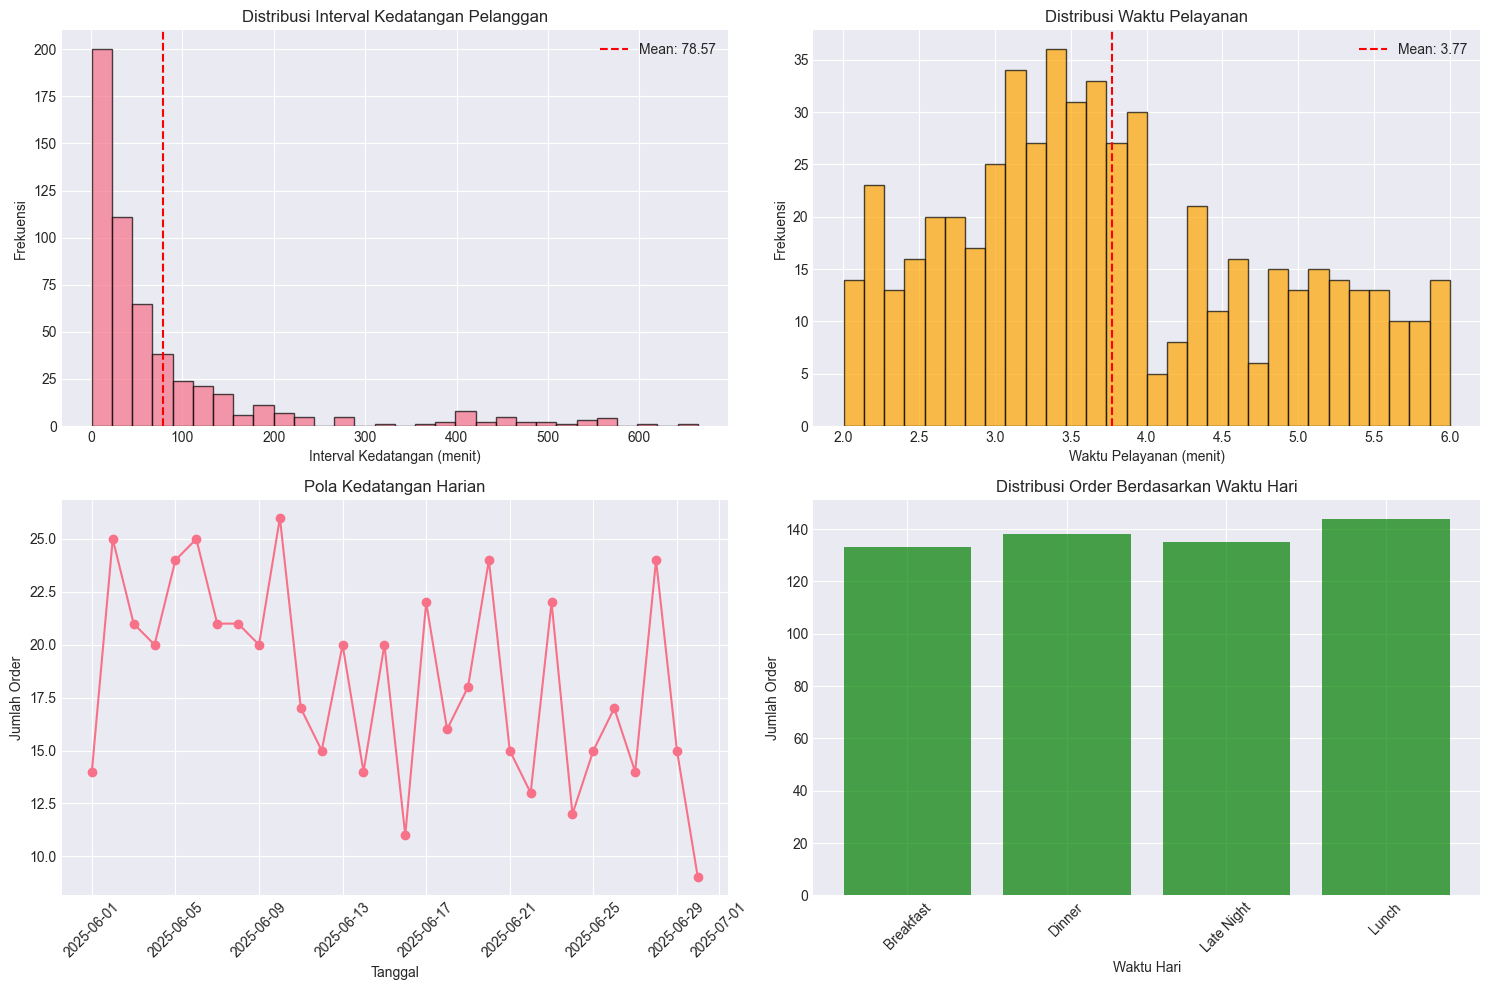


=== INSIGHT EDA ===
1. Rata-rata interval kedatangan: 78.57 menit
2. Rata-rata waktu pelayanan: 3.77 menit
3. Waktu sibuk: Lunch dengan 144 order


In [197]:
# Visualisasi EDA - Distribusi Interval Kedatangan
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Distribusi interval kedatangan
axes[0, 0].hist(arrival_intervals, bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Interval Kedatangan (menit)')
axes[0, 0].set_ylabel('Frekuensi')
axes[0, 0].set_title('Distribusi Interval Kedatangan Pelanggan')
axes[0, 0].axvline(np.mean(arrival_intervals), color='r', linestyle='--', 
                   label=f'Mean: {np.mean(arrival_intervals):.2f}')
axes[0, 0].legend()

# 2. Distribusi waktu pelayanan
axes[0, 1].hist(service_times, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Waktu Pelayanan (menit)')
axes[0, 1].set_ylabel('Frekuensi')
axes[0, 1].set_title('Distribusi Waktu Pelayanan')
axes[0, 1].axvline(np.mean(service_times), color='r', linestyle='--',
                   label=f'Mean: {np.mean(service_times):.2f}')
axes[0, 1].legend()

# 3. Pola kedatangan per hari
df['Date'] = df['OrderDate'].dt.date
daily_orders = df.groupby('Date').size()
axes[1, 0].plot(daily_orders.index, daily_orders.values, marker='o')
axes[1, 0].set_xlabel('Tanggal')
axes[1, 0].set_ylabel('Jumlah Order')
axes[1, 0].set_title('Pola Kedatangan Harian')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Pola kedatangan per waktu (TimeOfDay)
time_of_day_counts = df['TimeOfDay'].value_counts().sort_index()
axes[1, 1].bar(time_of_day_counts.index, time_of_day_counts.values, color='green', alpha=0.7)
axes[1, 1].set_xlabel('Waktu Hari')
axes[1, 1].set_ylabel('Jumlah Order')
axes[1, 1].set_title('Distribusi Order Berdasarkan Waktu Hari')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n=== INSIGHT EDA ===")
print(f"1. Rata-rata interval kedatangan: {np.mean(arrival_intervals):.2f} menit")
print(f"2. Rata-rata waktu pelayanan: {np.mean(service_times):.2f} menit")
print(f"3. Waktu sibuk: {time_of_day_counts.idxmax()} dengan {time_of_day_counts.max()} order")


In [198]:
# Parameter simulasi berdasarkan data riil
RANDOM_SEED = 42
SIM_TIME = 480  # 8 jam operasional (dalam menit)

# Parameter dari EDA
ARRIVAL_RATE = np.mean(arrival_intervals)  # Rata-rata interval kedatangan (menit)
SERVICE_TIME_MIN = np.percentile(service_times, 25)  # Q1 waktu pelayanan
SERVICE_TIME_MAX = np.percentile(service_times, 75)  # Q3 waktu pelayanan

print("=== PARAMETER SIMULASI ===")
print(f"Waktu simulasi: {SIM_TIME} menit ({SIM_TIME/60:.1f} jam)")
print(f"Rata-rata interval kedatangan: {ARRIVAL_RATE:.2f} menit")
print(f"Waktu pelayanan: {SERVICE_TIME_MIN:.2f} - {SERVICE_TIME_MAX:.2f} menit")
print(f"\nParameter ini akan digunakan untuk simulasi antrean.")


=== PARAMETER SIMULASI ===
Waktu simulasi: 480 menit (8.0 jam)
Rata-rata interval kedatangan: 78.57 menit
Waktu pelayanan: 3.01 - 4.56 menit

Parameter ini akan digunakan untuk simulasi antrean.


In [199]:
def run_simulation(num_cashiers, arrival_rate, service_min, service_max, sim_time, seed=42):
    """
    Menjalankan simulasi antrean restoran
    
    Parameters:
    -----------
    num_cashiers : int
        Jumlah kasir yang tersedia
    arrival_rate : float
        Rata-rata interval kedatangan (menit)
    service_min : float
        Waktu pelayanan minimum (menit)
    service_max : float
        Waktu pelayanan maksimum (menit)
    sim_time : float
        Waktu simulasi (menit)
    seed : int
        Random seed untuk reproducibility
    
    Returns:
    --------
    dict : Dictionary berisi hasil simulasi
    """
    random.seed(seed)
    
    waiting_times = []
    service_times = []
    total_service_time = 0.0
    customer_count = 0
    
    def customer(env, cashier):
        """Proses pelanggan dalam sistem antrean"""
        nonlocal total_service_time, customer_count
        customer_count += 1
        arrival_time = env.now
        
        # Request kasir
        with cashier.request() as request:
            yield request
            
            # Hitung waktu tunggu
            wait_time = env.now - arrival_time
            waiting_times.append(wait_time)
            
            # Proses pelayanan
            service_time = random.uniform(service_min, service_max)
            service_times.append(service_time)
            total_service_time += service_time
            
            yield env.timeout(service_time)
    
    def arrival_process(env, cashier):
        """Proses kedatangan pelanggan"""
        i = 0
        while True:
            # Interval kedatangan mengikuti distribusi eksponensial
            yield env.timeout(random.expovariate(1.0 / arrival_rate))
            i += 1
            env.process(customer(env, cashier))
    
    # Setup environment
    env = simpy.Environment()
    cashier = simpy.Resource(env, capacity=num_cashiers)
    env.process(arrival_process(env, cashier))
    env.run(until=sim_time)
    
    # Hitung metrik
    if len(waiting_times) > 0:
        avg_wait = statistics.mean(waiting_times)
        max_wait = max(waiting_times)
        median_wait = statistics.median(waiting_times)
    else:
        avg_wait = max_wait = median_wait = 0
    
    utilization = total_service_time / (num_cashiers * sim_time) if num_cashiers > 0 else 0
    
    return {
        'num_cashiers': num_cashiers,
        'total_customers': customer_count,
        'avg_wait_time': avg_wait,
        'max_wait_time': max_wait,
        'median_wait_time': median_wait,
        'utilization': utilization,
        'waiting_times': waiting_times,
        'service_times': service_times
    }

print("Fungsi simulasi berhasil didefinisikan!")


Fungsi simulasi berhasil didefinisikan!


In [200]:
# Jalankan simulasi untuk berbagai jumlah kasir
cashiers = [1, 2, 3]
results = []

for num_cash in cashiers:
    result = run_simulation(
        num_cashiers=num_cash,
        arrival_rate=ARRIVAL_RATE,
        service_min=SERVICE_TIME_MIN,
        service_max=SERVICE_TIME_MAX,
        sim_time=SIM_TIME,
        seed=RANDOM_SEED
    )
    results.append(result)
    print(f"Kasir = {num_cash}: "
          f"Pelanggan = {result['total_customers']}, "
          f"Rata-rata tunggu = {result['avg_wait_time']:.2f} menit, "
          f"Utilisasi = {result['utilization']:.2f}")

# Simpan hasil untuk visualisasi
sim_results_df = pd.DataFrame(results)
sim_results_df


Kasir = 1: Pelanggan = 11, Rata-rata tunggu = 0.56 menit, Utilisasi = 0.09
Kasir = 2: Pelanggan = 11, Rata-rata tunggu = 0.00 menit, Utilisasi = 0.04
Kasir = 3: Pelanggan = 11, Rata-rata tunggu = 0.00 menit, Utilisasi = 0.03


,num_cashiers,total_customers,avg_wait_time,max_wait_time,median_wait_time,utilization,waiting_times,service_times
0,1,11,0.561118,3.748708,0.0,0.086458,"[0.0, 1.4487934634170472, 0.0, 0.0, 0.0, 0.974...","[3.438809911375284, 4.153548970954056, 4.39472..."
1,2,11,0.000000,0.000000,0.0,0.043229,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.438809911375284, 4.153548970954056, 4.39472..."
2,3,11,0.000000,0.000000,0.0,0.028819,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.438809911375284, 4.153548970954056, 4.39472..."


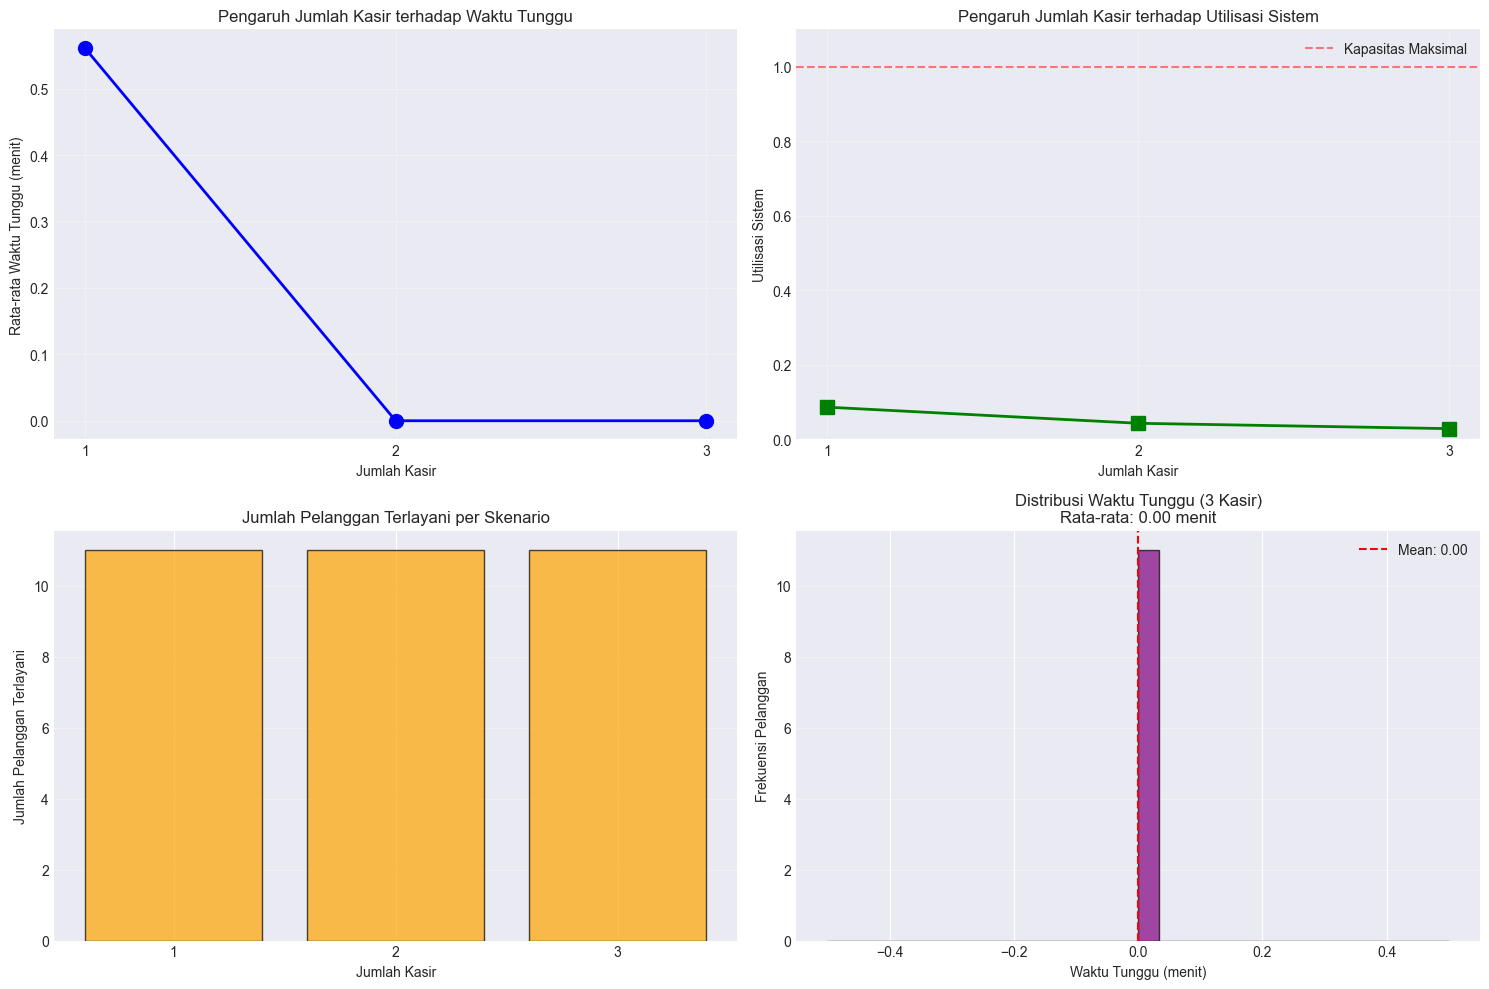

In [201]:
# Visualisasi hasil simulasi
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Rata-rata waktu tunggu vs jumlah kasir
axes[0, 0].plot(sim_results_df['num_cashiers'], sim_results_df['avg_wait_time'], 
                marker='o', linewidth=2, markersize=10, color='blue')
axes[0, 0].set_xlabel('Jumlah Kasir')
axes[0, 0].set_ylabel('Rata-rata Waktu Tunggu (menit)')
axes[0, 0].set_title('Pengaruh Jumlah Kasir terhadap Waktu Tunggu')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks([1, 2, 3])

# 2. Utilisasi sistem vs jumlah kasir
axes[0, 1].plot(sim_results_df['num_cashiers'], sim_results_df['utilization'], 
                marker='s', linewidth=2, markersize=10, color='green')
axes[0, 1].set_xlabel('Jumlah Kasir')
axes[0, 1].set_ylabel('Utilisasi Sistem')
axes[0, 1].set_title('Pengaruh Jumlah Kasir terhadap Utilisasi Sistem')
axes[0, 1].set_ylim(0, 1.1)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks([1, 2, 3])
axes[0, 1].axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='Kapasitas Maksimal')
axes[0, 1].legend()

# 3. Jumlah pelanggan terlayani vs jumlah kasir
axes[1, 0].bar(sim_results_df['num_cashiers'], sim_results_df['total_customers'], 
                color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Jumlah Kasir')
axes[1, 0].set_ylabel('Jumlah Pelanggan Terlayani')
axes[1, 0].set_title('Jumlah Pelanggan Terlayani per Skenario')
axes[1, 0].set_xticks([1, 2, 3])
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Distribusi waktu tunggu untuk skenario optimal (3 kasir)
optimal_result = results[2]  # Index 2 = 3 kasir
axes[1, 1].hist(optimal_result['waiting_times'], bins=30, edgecolor='black', 
                alpha=0.7, color='purple')
axes[1, 1].set_xlabel('Waktu Tunggu (menit)')
axes[1, 1].set_ylabel('Frekuensi Pelanggan')
axes[1, 1].set_title(f'Distribusi Waktu Tunggu (3 Kasir)\nRata-rata: {optimal_result["avg_wait_time"]:.2f} menit')
axes[1, 1].axvline(optimal_result['avg_wait_time'], color='r', linestyle='--', 
                   label=f'Mean: {optimal_result["avg_wait_time"]:.2f}')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


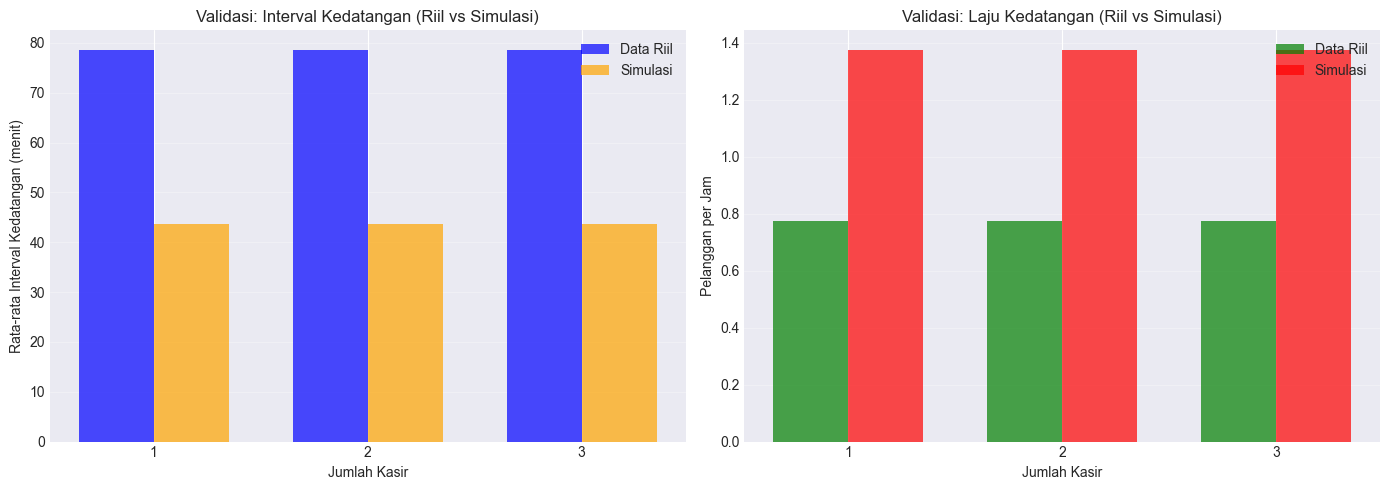


=== VALIDASI MODEL ===
Data Riil - Rata-rata interval: 78.57 menit
Data Riil - Pelanggan per jam: 0.77

Simulasi (3 kasir) - Rata-rata interval: 43.64 menit
Simulasi (3 kasir) - Pelanggan per jam: 1.38


In [202]:
# Validasi: Bandingkan rata-rata interval kedatangan simulasi vs data riil
# Dari simulasi, kita bisa hitung rata-rata interval kedatangan aktual
sim_arrival_intervals = []
for result in results:
    if result['total_customers'] > 0:
        # Rata-rata interval = waktu simulasi / jumlah pelanggan
        avg_interval = SIM_TIME / result['total_customers']
        sim_arrival_intervals.append(avg_interval)
    else:
        sim_arrival_intervals.append(0)

# Visualisasi perbandingan
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Perbandingan interval kedatangan
x_pos = np.arange(len(cashiers))
width = 0.35

axes[0].bar(x_pos - width/2, [ARRIVAL_RATE]*len(cashiers), width, 
            label='Data Riil', alpha=0.7, color='blue')
axes[0].bar(x_pos + width/2, sim_arrival_intervals, width, 
            label='Simulasi', alpha=0.7, color='orange')
axes[0].set_xlabel('Jumlah Kasir')
axes[0].set_ylabel('Rata-rata Interval Kedatangan (menit)')
axes[0].set_title('Validasi: Interval Kedatangan (Riil vs Simulasi)')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(cashiers)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Perbandingan jumlah pelanggan
real_customers_per_hour = arrival_rate_real
sim_customers_per_hour = [r['total_customers'] / (SIM_TIME/60) for r in results]

axes[1].bar(x_pos - width/2, [real_customers_per_hour]*len(cashiers), width,
            label='Data Riil', alpha=0.7, color='green')
axes[1].bar(x_pos + width/2, sim_customers_per_hour, width,
            label='Simulasi', alpha=0.7, color='red')
axes[1].set_xlabel('Jumlah Kasir')
axes[1].set_ylabel('Pelanggan per Jam')
axes[1].set_title('Validasi: Laju Kedatangan (Riil vs Simulasi)')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(cashiers)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n=== VALIDASI MODEL ===")
print(f"Data Riil - Rata-rata interval: {ARRIVAL_RATE:.2f} menit")
print(f"Data Riil - Pelanggan per jam: {real_customers_per_hour:.2f}")
print(f"\nSimulasi (3 kasir) - Rata-rata interval: {sim_arrival_intervals[2]:.2f} menit")
print(f"Simulasi (3 kasir) - Pelanggan per jam: {sim_customers_per_hour[2]:.2f}")
